# MG dataset

Here we explore why natural gradient descent performes worse than (conventional) gradient descent in our experiments

In [1]:
import sys
sys.path.append('/Users/IzmailovPavel/Documents/Education/Course Project/Code')
import numpy as np
import matplotlib as mpl

from matplotlib import pyplot as plt

from GP.covariance_functions import SquaredExponential
from GP.gaussian_process_regression import GPR

from sklearn.cluster import KMeans

from sklearn.datasets import load_svmlight_file
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.svm import SVR
from sklearn.metrics import r2_score
%matplotlib inline
%load_ext autoreload
%autoreload 2

Loading the data

In [2]:
x_tr, y_tr = load_svmlight_file('../../../../Programming/DataSets/Regression/mg(1385, 6).txt')
x_tr, y_tr = shuffle(x_tr, y_tr, random_state=241)
data_name = 'mg'
file_name = data_name

x_tr = x_tr.toarray().T
scaler_x = StandardScaler()
scaler_y = StandardScaler()

y_tr = y_tr.reshape((y_tr.size, 1))
x_test = x_tr[:, int(x_tr.shape[1] * 0.8):]
y_test = y_tr[int(x_tr.shape[1] * 0.8):, :]
y_tr = y_tr[:int(x_tr.shape[1] * 0.8), :]
x_tr = x_tr[:, : int(x_tr.shape[1] * 0.8)]


x_tr = scaler_x.fit_transform(x_tr.T).T
x_test = scaler_x.transform(x_test.T).T
y_tr = scaler_y.fit_transform(y_tr)
y_test = scaler_y.transform(y_test)


dim, num = x_tr.shape
print('of objects:', num)
print('of features', dim)
print(data_name)

of objects: 1108
of features 6
mg


## SVM
We train an SVM with RBF kernel for reference.

In [3]:
svm = SVR(C=5e-1)
svm.fit(x_tr.T, y_tr[:, 0])
pred = svm.predict(x_test.T)
r2_score(y_test, pred)

0.74057253616984964

# K-means cluster centers as inducing inputs

We use K-means cluster centers as inducing point positions and don't optimize wrt them.

In [4]:
ind_num = 100
print('Finding means...')
means = KMeans(n_clusters=ind_num, n_init=3, max_iter=100, random_state=241)
means.fit(x_tr.T)
inputs = means.cluster_centers_.T
print('...found')

Finding means...
...found


In [5]:
cov_params = np.array([1.0, 5., 1.0])

## Full gradient vs Full natural gradient
### SVI, Conventionl gradients

In [6]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
fg_svi_gp = GPR(model_covariance_obj, method='svi', parametrization='cholesky', optimizer='climinSG')

In [7]:
opts = {'mydisp': True, 'print_freq': 50, 'step_rate': .45,
                'maxiter': 1500, 'batch_size': x_tr.shape[1] }
fg_svi_res = fg_svi_gp.fit(x_tr, y_tr, num_inputs=ind_num, optimizer_options=opts, inputs=inputs)

Using SG optimizer
Iteration  50 :
	Gradient norm 0.270691647203
Iteration  100 :
	Gradient norm 0.288389311152
Iteration  150 :
	Gradient norm 0.303399717552
Iteration  200 :
	Gradient norm 0.317220295586
Iteration  250 :
	Gradient norm 0.330358284467
Iteration  300 :
	Gradient norm 0.343298852038
Iteration  350 :
	Gradient norm 0.356549735204
Iteration  400 :
	Gradient norm 0.370647451843
Iteration  450 :
	Gradient norm 0.386102450597
Iteration  500 :
	Gradient norm 0.403259390002
Iteration  550 :
	Gradient norm 0.422116700677
Iteration  600 :
	Gradient norm 0.442251127471
Iteration  650 :
	Gradient norm 0.46293729085
Iteration  700 :
	Gradient norm 0.483322429755
Iteration  750 :
	Gradient norm 0.502498561089
Iteration  800 :
	Gradient norm 0.519577471982
Iteration  850 :
	Gradient norm 0.533944952812
Iteration  900 :
	Gradient norm 0.545538275905
Iteration  950 :
	Gradient norm 0.437379431595
Iteration  1000 :
	Gradient norm 0.579406347674
Iteration  1050 :
	Gradient norm 0.5979164

In [8]:
metric = lambda w: fg_svi_gp.get_prediction_quality(w, x_test, y_test)
fg_svi_x_lst, fg_svi_y_lst = fg_svi_res.plot_performance(metric, 'i', freq=10)

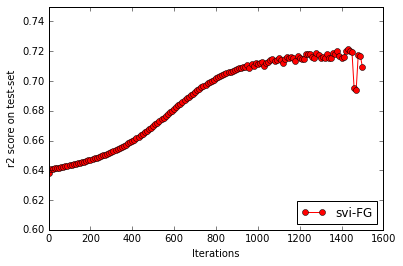

In [9]:
plt.plot(fg_svi_x_lst, fg_svi_y_lst, '-ro', label='svi-FG')
plt.ylim([.6, .75])
plt.legend(loc=4)
plt.xlabel('Iterations')
plt.ylabel('r2 score on test-set')

In [10]:
np.save('../plots/regression_revision/nat_grad_experiment/'+ data_name +'_fg_svi_x.npy', fg_svi_x_lst)
np.save('../plots/regression_revision/nat_grad_experiment/'+ data_name +'_fg_svi_y.npy', fg_svi_y_lst)

###SVI, Natural gradients

In [11]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
fng_svi_gp = GPR(model_covariance_obj, method='svi', parametrization='natural', optimizer='climinSG')

In [12]:
opts = {'mydisp': True, 'print_freq': 50, 'step_rate': .47,
                'maxiter': 2000, 'batch_size': x_tr.shape[1] }
fng_svi_res = fng_svi_gp.fit(x_tr, y_tr, num_inputs=ind_num, optimizer_options=opts, inputs=inputs)

1.0
Using SG optimizer
Iteration  50 :
	Gradient norm 0.339368544385
Iteration  100 :
	Gradient norm 0.346469874503
Iteration  150 :
	Gradient norm 0.352949927101
Iteration  200 :
	Gradient norm 0.359375934168
Iteration  250 :
	Gradient norm 0.365869600528
Iteration  300 :
	Gradient norm 0.372576411852
Iteration  350 :
	Gradient norm 0.379678294614
Iteration  400 :
	Gradient norm 0.387406065883
Iteration  450 :
	Gradient norm 0.396049888406
Iteration  500 :
	Gradient norm 0.405958495116
Iteration  550 :
	Gradient norm 0.417507624786
Iteration  600 :
	Gradient norm 0.431006170677
Iteration  650 :
	Gradient norm 0.446509060694
Iteration  700 :
	Gradient norm 0.463549674129
Iteration  750 :
	Gradient norm 0.480933755566
Iteration  800 :
	Gradient norm 0.496933119573
Iteration  850 :
	Gradient norm 0.510117979185
Iteration  900 :
	Gradient norm 0.520192853
Iteration  950 :
	Gradient norm 0.527833857169
Iteration  1000 :
	Gradient norm 0.533786741354
Iteration  1050 :
	Gradient norm 0.58902

In [13]:
metric = lambda w: fng_svi_gp.get_prediction_quality(w, x_test, y_test)
fng_svi_x_lst, fng_svi_y_lst = fng_svi_res.plot_performance(metric, 'i', freq=10)

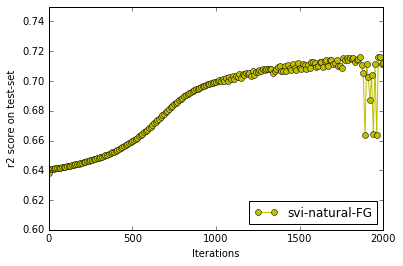

In [14]:
plt.plot(fng_svi_x_lst, fng_svi_y_lst, '-yo', label='svi-natural-FG')
plt.ylim([.6, .75])
plt.legend(loc=4)
plt.xlabel('Iterations')
plt.ylabel('r2 score on test-set')

In [15]:
np.save('../plots/regression_revision/nat_grad_experiment/'+ data_name +'_fng_svi_x.npy', fng_svi_x_lst)
np.save('../plots/regression_revision/nat_grad_experiment/'+ data_name +'_fng_svi_y.npy', fng_svi_y_lst)

### Introducing separate step multiplier for natural gradient

In [16]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
exp_fng_svi_gp = GPR(model_covariance_obj, method='svi', parametrization='natural', optimizer='climinSG')

In [17]:
opts = {'mydisp': True, 'print_freq': 50, 'step_rate': .4,
                'maxiter': 1000, 'batch_size': x_tr.shape[1], 'nat_mult':7.}
exp_fng_svi_res = exp_fng_svi_gp.fit(x_tr, y_tr, num_inputs=ind_num, optimizer_options=opts, inputs=inputs)

7.0
Using SG optimizer
Iteration  50 :
	Gradient norm 0.515077352406
Iteration  100 :
	Gradient norm 0.484826301774
Iteration  150 :
	Gradient norm 0.457469963332
Iteration  200 :
	Gradient norm 0.434456664427
Iteration  250 :
	Gradient norm 0.417517133273
Iteration  300 :
	Gradient norm 0.407227753569
Iteration  350 :
	Gradient norm 0.400420078212
Iteration  400 :
	Gradient norm 0.382437677953
Iteration  450 :
	Gradient norm 0.349695634182
Iteration  500 :
	Gradient norm 0.381922570987
Iteration  550 :
	Gradient norm 0.417150893088
Iteration  600 :
	Gradient norm 0.454424384555
Iteration  650 :
	Gradient norm 0.492393372178
Iteration  700 :
	Gradient norm 0.528665141052
Iteration  750 :
	Gradient norm 0.560368267949
Iteration  800 :
	Gradient norm 0.585885432464
Iteration  850 :
	Gradient norm 0.605730838311
Iteration  900 :
	Gradient norm 0.621493178587
Iteration  950 :
	Gradient norm 0.634590033398
Iteration  1000 :
	Gradient norm 0.645907238107


In [18]:
metric = lambda w: fng_svi_gp.get_prediction_quality(w, x_test, y_test)
exp_fng_svi_x_lst, exp_fng_svi_y_lst = exp_fng_svi_res.plot_performance(metric, 'i', freq=10)

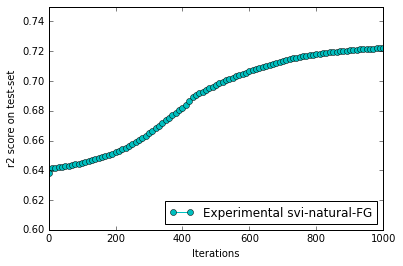

In [19]:
plt.plot(exp_fng_svi_x_lst, exp_fng_svi_y_lst, '-co', label='Experimental svi-natural-FG')
plt.ylim([.6, .75])
plt.legend(loc=4)
plt.xlabel('Iterations')
plt.ylabel('r2 score on test-set')

In [20]:
np.save('../plots/regression_revision/nat_grad_experiment/'+ data_name +'_exp_fng_svi_x.npy', exp_fng_svi_x_lst)
np.save('../plots/regression_revision/nat_grad_experiment/'+ data_name +'_exp_fng_svi_y.npy', exp_fng_svi_y_lst)

## Conclusion

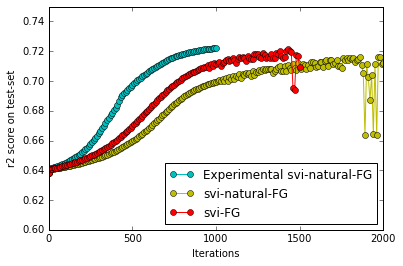

In [21]:
plt.plot(exp_fng_svi_x_lst, exp_fng_svi_y_lst, '-co', label='Experimental svi-natural-FG')
plt.plot(fng_svi_x_lst, fng_svi_y_lst, '-yo', label='svi-natural-FG')
plt.plot(fg_svi_x_lst, fg_svi_y_lst, '-ro', label='svi-FG')
plt.ylim([.6, .75])
plt.legend(loc=4)
plt.xlabel('Iterations')
plt.ylabel('r2 score on test-set')